In [1]:
%pylab inline

import os
from scipy.interpolate import interp1d as linear
from scipy.ndimage.filters import gaussian_filter
from scipy.misc import derivative
from scipy.stats import norm

from densitycontour import densitycontour

from styles.paper import *
from styles.colors import *
from styles.labels import *

from tools.plots import *
from tools.stats import *

greys_map = cm._generate_cmap(greys_map_name, 256)

Populating the interactive namespace from numpy and matplotlib


In [2]:
change_name = lambda name, strip: "spSpec"+name.lstrip(strip).replace(".log", ".fit")

def gaussian(x, std):
    return 1.0/sqrt(2*pi*std**2) * exp(-0.5*x**2/std**2)

In [3]:
#load G05 indices from SDSS sample
catalog = genfromtxt("data/sample-obs/catalog.txt", dtype=None, names=True)

g05_table = genfromtxt(os.path.expandvars("$phd/notebooks/data/sample-obs/G05_indexes_sample.txt"), dtype=None, names=True)

g05_mod_name = loadtxt(os.path.expandvars("$phd/notebooks/data/sample-obs/G05_indexes_from_mod.log"), dtype=np.str, usecols=(0,))
g05_mindx = loadtxt(os.path.expandvars("$phd/notebooks/data/sample-obs/G05_indexes_from_mod.log"), usecols=(1,2,3,4,5))
g05_mindx = g05_mindx[argsort(g05_mod_name)]

g05_obs_name = loadtxt(os.path.expandvars("$phd/notebooks/data/sample-obs/G05_indexes_from_obs.log"), dtype=np.str, usecols=(0,))
g05_oindx = loadtxt(os.path.expandvars("$phd/notebooks/data/sample-obs/G05_indexes_from_obs.log"), usecols=(1,2,3,4,5))
g05_oindx = g05_oindx[argsort(g05_obs_name)]

g05_ssag = loadtxt(os.path.expandvars("$phd/notebooks/data/sample-sim/G05_indexes_from_ndssag.log"), usecols=(1,2,3,4,5,6,7,8,9,10,11,12))
g05_ssag_dusty = loadtxt(os.path.expandvars("$phd/notebooks/data/sample-sim/G05_indexes_from_ssag.log"), usecols=(1,2,3,4,5,6,7,8,9,10,11,12))

m16_param = genfromtxt(os.path.expandvars("$phd/inputs/real_deal/outs/spec/dynbas_output.log"), dtype=None, names=True)
m16_param["input_file"] = array([change_name(name, "dynbasfit_processed_SPEC_") for name in m16_param["input_file"]])

g05_param = genfromtxt(os.path.expandvars("$phd/notebooks/data/sample-obs/gal2005.txt"), dtype=None, names=True)

cat_in_g05 = array([gal in g05_param["input_file"] for gal in catalog["input_file"]], dtype=np.bool)
m16_in_g05 = array([gal in g05_param["input_file"] for gal in m16_param["input_file"]], dtype=np.bool)

print all(g05_param["input_file"]==catalog["input_file"][cat_in_g05])
print all(m16_param["input_file"][m16_in_g05]==catalog["input_file"][cat_in_g05])
print all(np.sort(g05_mod_name)[m16_in_g05]==catalog["input_file"][cat_in_g05])
print all(np.sort(g05_obs_name)[m16_in_g05]==g05_table["input_file"][m16_in_g05])

True
True
True
True


In [4]:
cat = catalog[cat_in_g05]
m16 = m16_param[m16_in_g05]
g05 = g05_param

f = list(g05_table.dtype.names[:6])+["u-r"]+list(g05_table.dtype.names[6:])+["u-r_err"]
dt = zip(f, ["|S25"]+(len(f)-1)*['<f8'])

obs = np.zeros(g05_table[m16_in_g05].size, dtype=dt)
mod = np.zeros(g05_table[m16_in_g05].size, dtype=dt)

ssa = np.zeros(g05_ssag.shape[0], dtype=[('D4000', '<f8'),
                                         ('Hbeta', '<f8'),
                                         ('Hdg', '<f8'),
                                         ('Mg2Fe', '<f8'),
                                         ('MgFep', '<f8'),
                                         ('age', '<f8'),
                                         ('met', '<f8'),
                                         ('u-r', '<f8')])
ssa_dusty = np.zeros(g05_ssag.shape[0], dtype=[('D4000', '<f8'),
                                               ('Hbeta', '<f8'),
                                               ('Hdg', '<f8'),
                                               ('Mg2Fe', '<f8'),
                                               ('MgFep', '<f8'),
                                               ('age', '<f8'),
                                               ('met', '<f8'),
                                               ('u-r', '<f8')])

for i, kw in enumerate("D4000 Hbeta Hdg Mg2Fe MgFep u-r".split()): mod[kw] = g05_mindx[m16_in_g05, i] if kw!="u-r" else cat["u_mag"]-cat["r_mag"]
for i, kw in enumerate("D4000 Hbeta Hdg Mg2Fe MgFep u-r".split()): obs[kw] = g05_oindx[m16_in_g05, i] if kw!="u-r" else cat["u_mag"]-cat["r_mag"]
for kw in "input_file D4000_err Hbeta_err Hdg_err Mg2Fe_err MgFep_err u-r_err".split(): mod[kw] = g05_table[m16_in_g05][kw] if kw!="u-r_err" else sqrt(cat["u_err"]**2+cat["r_err"]**2)
for kw in "input_file D4000_err Hbeta_err Hdg_err Mg2Fe_err MgFep_err u-r_err".split(): obs[kw] = g05_table[m16_in_g05][kw] if kw!="u-r_err" else sqrt(cat["u_err"]**2+cat["r_err"]**2)
for i, kw in enumerate("D4000 Hbeta Hdg Mg2Fe MgFep age met u-r".split()): ssa[kw] = g05_ssag[:, i] if kw!="u-r" else g05_ssag[:, 7]-g05_ssag[:, 9]
for i, kw in enumerate("D4000 Hbeta Hdg Mg2Fe MgFep age met u-r".split()): ssa_dusty[kw] = g05_ssag_dusty[:, i] if kw!="u-r" else g05_ssag_dusty[:, 7]-g05_ssag_dusty[:, 9]

g_z_red = ssa_dusty["u-r"] - ssa["u-r"]
ssa["age"] = log10(ssa["age"])
ssa_dusty["age"] = log10(ssa_dusty["age"])

ssa = ssa[(ssa["met"]>=0.02)&(ssa["met"]<=2.5)]
ssa_dusty = ssa_dusty[(ssa_dusty["met"]>=0.02)&(ssa_dusty["met"]<=2.5)]
def log_pdf(x, range):
    a, b = range
    
    if hasattr(x, "__getitem__") and (x[0]==a and x[-1]==b):
        x_ = x
    else:
        x_ = linspace(a, b, 1000)
    
    return (log(x)-log(a))/trapz(log(x_)-log(a), x_)

u = rand(ssa.size)
#ssa = ssa[u<log_pdf(ssa["met"], range=(0.02,2.5))/log_pdf(2.5, range=(0.02,2.5))]
#ssa_dusty = ssa_dusty[u<log_pdf(ssa_dusty["met"], range=(0.02,2.5))/log_pdf(2.5, range=(0.02,2.5))]

ssa["met"] = log10(ssa["met"])
ssa_dusty["met"] = log10(ssa_dusty["met"])

col = cat["u_mag"]-cat["r_mag"]

In [5]:
idir = os.path.expandvars("$phd/notebooks/data/ssp-model-props")
odir = os.path.expandvars("$HOME/Documents/Publications/mejia+2016/")

ax_xlabel = {
    "age": r"\bf \log{t/\text{yr}}"
}
ax_ylabels = {
    "D4000": r"\bf D$4000$",
    "Hbeta": r"\bf H$\beta$",
    "Hdg": r"\bf H$\delta_A$+H$\gamma_A$",
    "Mg2Fe": r"\bf [Mg${}_2$Fe]",
    "MgFep": r"\bf [MgFe]'",
    "CaII triplet": r"\bf Ca\textsc{ii} Triplet",
    "u-g": r"\bf $u-g$",
    "u-r": r"\bf $u-r$",
    "g-r": r"\bf $g-r$",
    "g-i": r"\bf $g-i$",
    "g-z": r"\bf $g-z$",
    "r-i": r"\bf $r-i$",
    "r-z": r"\bf $r-z$",
    "i-z": r"\bf $i-z$",
    "M/L_u": r"\bf $M_\star/L_u$",
    "M/L_g": r"\bf $M_\star/L_g$",
    "M/L_r": r"\bf $M_\star/L_r$",
    "M/L_i": r"\bf $M_\star/L_i$",
    "M/L_z": r"\bf $M_\star/L_z$",
    "L_u": r"\bf $L_u$",
    "L_g": r"\bf $L_g$",
    "L_r": r"\bf $L_r$",
    "L_i": r"\bf $L_i$",
    "L_z": r"\bf $L_z$"
}
libraries = {
    "stelib": {
        "m32": r"0.02",
        "m42": r"0.20",
        "m52": r"0.40",
        "m62": r"1.00",
        "m72": r"2.50"
    },
    "miles": {
        "z001": r"0.06",
        "z004": r"0.23",
        "z008": r"0.47",
        "z017": r"1.00",
        "z030": r"1.76",
        "z040": r"2.35"
    }
}
metallicities = {
    r"0.0004": ("m32", "stelib"),
    r"0.004": ("m42", "stelib"),
    r"0.008": ("m52", "stelib"),
    r"0.02": ("m62", "stelib"),
    r"0.05": ("m72", "stelib"),
    r"0.001": ("z001", "miles"),
    r"0.004": ("z004", "miles"),
    r"0.008": ("z008", "miles"),
    r"0.017": ("z017", "miles"),
    r"0.03": ("z030", "miles"),
    r"0.04": ("z040", "miles")
}
indx_maps = {
    "6lsindx_sed": {
        "Mg2": 12,
        "Hbeta": 9,
        "Fe4531": 7,
        "Fe5015": 10,
        "Mgb": 13,
        "Fe5270": 14,
        "Fe5335": 15,
    },
    "7lsindx_sed": {
        "Hdelta_A": 2,
        "Hgamma_A": 3,
        "D4000": 5,
        "CaII8498": 7,
        "CaII8542": 8,
        "CaII8662": 9
    },
    "1ABmag": {
        "u-g": ((1,3), lambda mags: mags[:,0]-mags[:,1]),
        "u-r": ((1,3), lambda mags: mags[:,0]-mags[:,1]),
        "g-r": ((2,3), lambda mags: mags[:,0]-mags[:,1]),
        "g-i": ((2,4), lambda mags: mags[:,0]-mags[:,1]),
        "g-z": ((2,5), lambda mags: mags[:,0]-mags[:,1]),
        "r-i": ((3,4), lambda mags: mags[:,0]-mags[:,1]),
        "r-z": ((3,5), lambda mags: mags[:,0]-mags[:,1]),
        "i-z": ((4,5), lambda mags: mags[:,0]-mags[:,1]),
        "L_u": (1, lambda mag: 10**(-0.4*(mag-5.46))),
        "L_g": (2, lambda mag: 10**(-0.4*(mag-5.21))),
        "L_r": (3, lambda mag: 10**(-0.4*(mag-4.50))),
        "L_i": (4, lambda mag: 10**(-0.4*(mag-4.16))),
        "L_z": (5, lambda mag: 10**(-0.4*(mag-3.99)))
    }
}
file_maps = {
    "tau0": {
        "1color": {
            "age": 0
        },
        "4color": {
            "M": 5
        }
    },
    "tau2": {
        "w_age_rf": {
            "age": 13
        },
        "4color": {
            "M": 5
        }
    },
    "tau5": {
        "w_age_rf": {
            "age": 13
        },
        "4color": {
            "M": 5
        }
    }
}
for modl in file_maps: file_maps[modl].update(indx_maps)

Mg2Fe = lambda Mg2, Fe4531, Fe5015: 0.6*Mg2 + 0.4*log10(abs(Fe4531+Fe5015))
MgFep = lambda Mgb, Fe5270, Fe5335: sqrt(abs(Mgb*(0.72*Fe5270+0.28*Fe5335)))
Hdg = lambda Hdelta, Hgamma: Hdelta + Hgamma
CaII_triplet = lambda CaII8498, CaII8542, CaII8662: CaII8498 + CaII8542 + CaII8662
MLum = lambda M, L: M/L
MLum_err = lambda MLR: MLR*(0.05/1.0857)

def walk_map(library, model):
    return {
        zkw: {
            field: loadtxt("{}/{}/{}_{}.{}".format(idir,library,model,zkw,ftype), usecols=(icol,)) if not hasattr(icol,"__getitem__") else icol[1](loadtxt("{}/{}/{}_{}.{}".format(idir,library,model,zkw,ftype), usecols=((icol[0],) if not hasattr(icol[0],"__getitem__") else icol[0]))) for ftype in file_maps[model] for field, icol in file_maps[model][ftype].iteritems()
        } for zkw in libraries[library]
    }

def add_ingredient(stores, ingredients_list, directions, ingredient_name):
    for store in stores.values():
        store[ingredient_name] = directions(*tuple(store[ingredient] for ingredient in ingredients_list))
    return None

In [6]:
tau0_stelib = walk_map("stelib", "tau0")
tau2_stelib = walk_map("stelib", "tau2")
tau5_stelib = walk_map("stelib", "tau5")

add_ingredient(tau0_stelib, ("Mg2","Fe4531","Fe5015"), Mg2Fe, "Mg2Fe")
add_ingredient(tau0_stelib, ("Mgb","Fe5270","Fe5335"), MgFep, "MgFep")
add_ingredient(tau0_stelib, ("Hdelta_A","Hgamma_A"), Hdg, "Hdg")
add_ingredient(tau0_stelib, ("M", "L_u"), MLum, "M/L_u")
add_ingredient(tau0_stelib, ("M", "L_g"), MLum, "M/L_g")
add_ingredient(tau0_stelib, ("M", "L_r"), MLum, "M/L_r")
add_ingredient(tau0_stelib, ("M", "L_i"), MLum, "M/L_i")
add_ingredient(tau0_stelib, ("M", "L_z"), MLum, "M/L_z")
add_ingredient(tau0_stelib, ("M/L_u",), MLum_err, "err_M/L_u")
add_ingredient(tau0_stelib, ("M/L_g",), MLum_err, "err_M/L_g")
add_ingredient(tau0_stelib, ("M/L_r",), MLum_err, "err_M/L_r")
add_ingredient(tau0_stelib, ("M/L_i",), MLum_err, "err_M/L_i")
add_ingredient(tau0_stelib, ("M/L_z",), MLum_err, "err_M/L_z")

add_ingredient(tau2_stelib, ("Mg2","Fe4531","Fe5015"), Mg2Fe, "Mg2Fe")
add_ingredient(tau2_stelib, ("Mgb","Fe5270","Fe5335"), MgFep, "MgFep")
add_ingredient(tau2_stelib, ("Hdelta_A","Hgamma_A"), Hdg, "Hdg")
add_ingredient(tau2_stelib, ("M", "L_u"), MLum, "M/L_u")
add_ingredient(tau2_stelib, ("M", "L_g"), MLum, "M/L_g")
add_ingredient(tau2_stelib, ("M", "L_r"), MLum, "M/L_r")
add_ingredient(tau2_stelib, ("M", "L_i"), MLum, "M/L_i")
add_ingredient(tau2_stelib, ("M", "L_z"), MLum, "M/L_z")
add_ingredient(tau2_stelib, ("M/L_u",), MLum_err, "err_M/L_u")
add_ingredient(tau2_stelib, ("M/L_g",), MLum_err, "err_M/L_g")
add_ingredient(tau2_stelib, ("M/L_r",), MLum_err, "err_M/L_r")
add_ingredient(tau2_stelib, ("M/L_i",), MLum_err, "err_M/L_i")
add_ingredient(tau2_stelib, ("M/L_z",), MLum_err, "err_M/L_z")

add_ingredient(tau5_stelib, ("Mg2","Fe4531","Fe5015"), Mg2Fe, "Mg2Fe")
add_ingredient(tau5_stelib, ("Mgb","Fe5270","Fe5335"), MgFep, "MgFep")
add_ingredient(tau5_stelib, ("Hdelta_A","Hgamma_A"), Hdg, "Hdg")
add_ingredient(tau5_stelib, ("M", "L_u"), MLum, "M/L_u")
add_ingredient(tau5_stelib, ("M", "L_g"), MLum, "M/L_g")
add_ingredient(tau5_stelib, ("M", "L_r"), MLum, "M/L_r")
add_ingredient(tau5_stelib, ("M", "L_i"), MLum, "M/L_i")
add_ingredient(tau5_stelib, ("M", "L_z"), MLum, "M/L_z")
add_ingredient(tau5_stelib, ("M/L_u",), MLum_err, "err_M/L_u")
add_ingredient(tau5_stelib, ("M/L_g",), MLum_err, "err_M/L_g")
add_ingredient(tau5_stelib, ("M/L_r",), MLum_err, "err_M/L_r")
add_ingredient(tau5_stelib, ("M/L_i",), MLum_err, "err_M/L_i")
add_ingredient(tau5_stelib, ("M/L_z",), MLum_err, "err_M/L_z")

In [7]:
tau0_miles = walk_map("miles", "tau0")
tau2_miles = walk_map("miles", "tau2")
tau5_miles = walk_map("miles", "tau5")

add_ingredient(tau0_miles, ("Mg2","Fe4531","Fe5015"), Mg2Fe, "Mg2Fe")
add_ingredient(tau0_miles, ("Mgb","Fe5270","Fe5335"), MgFep, "MgFep")
add_ingredient(tau0_miles, ("Hdelta_A","Hgamma_A"), Hdg, "Hdg")
add_ingredient(tau0_miles, ("M", "L_u"), MLum, "M/L_u")
add_ingredient(tau0_miles, ("M", "L_g"), MLum, "M/L_g")
add_ingredient(tau0_miles, ("M", "L_r"), MLum, "M/L_r")
add_ingredient(tau0_miles, ("M", "L_i"), MLum, "M/L_i")
add_ingredient(tau0_miles, ("M", "L_z"), MLum, "M/L_z")
add_ingredient(tau0_miles, ("M/L_u",), MLum_err, "err_M/L_u")
add_ingredient(tau0_miles, ("M/L_g",), MLum_err, "err_M/L_g")
add_ingredient(tau0_miles, ("M/L_r",), MLum_err, "err_M/L_r")
add_ingredient(tau0_miles, ("M/L_i",), MLum_err, "err_M/L_i")
add_ingredient(tau0_miles, ("M/L_z",), MLum_err, "err_M/L_z")

add_ingredient(tau2_miles, ("Mg2","Fe4531","Fe5015"), Mg2Fe, "Mg2Fe")
add_ingredient(tau2_miles, ("Mgb","Fe5270","Fe5335"), MgFep, "MgFep")
add_ingredient(tau2_miles, ("Hdelta_A","Hgamma_A"), Hdg, "Hdg")
add_ingredient(tau2_miles, ("M", "L_u"), MLum, "M/L_u")
add_ingredient(tau2_miles, ("M", "L_g"), MLum, "M/L_g")
add_ingredient(tau2_miles, ("M", "L_r"), MLum, "M/L_r")
add_ingredient(tau2_miles, ("M", "L_i"), MLum, "M/L_i")
add_ingredient(tau2_miles, ("M", "L_z"), MLum, "M/L_z")
add_ingredient(tau2_miles, ("M/L_u",), MLum_err, "err_M/L_u")
add_ingredient(tau2_miles, ("M/L_g",), MLum_err, "err_M/L_g")
add_ingredient(tau2_miles, ("M/L_r",), MLum_err, "err_M/L_r")
add_ingredient(tau2_miles, ("M/L_i",), MLum_err, "err_M/L_i")
add_ingredient(tau2_miles, ("M/L_z",), MLum_err, "err_M/L_z")

add_ingredient(tau5_miles, ("Mg2","Fe4531","Fe5015"), Mg2Fe, "Mg2Fe")
add_ingredient(tau5_miles, ("Mgb","Fe5270","Fe5335"), MgFep, "MgFep")
add_ingredient(tau5_miles, ("Hdelta_A","Hgamma_A"), Hdg, "Hdg")
add_ingredient(tau5_miles, ("M", "L_u"), MLum, "M/L_u")
add_ingredient(tau5_miles, ("M", "L_g"), MLum, "M/L_g")
add_ingredient(tau5_miles, ("M", "L_r"), MLum, "M/L_r")
add_ingredient(tau5_miles, ("M", "L_i"), MLum, "M/L_i")
add_ingredient(tau5_miles, ("M", "L_z"), MLum, "M/L_z")
add_ingredient(tau5_miles, ("M/L_u",), MLum_err, "err_M/L_u")
add_ingredient(tau5_miles, ("M/L_g",), MLum_err, "err_M/L_g")
add_ingredient(tau5_miles, ("M/L_r",), MLum_err, "err_M/L_r")
add_ingredient(tau5_miles, ("M/L_i",), MLum_err, "err_M/L_i")
add_ingredient(tau5_miles, ("M/L_z",), MLum_err, "err_M/L_z")

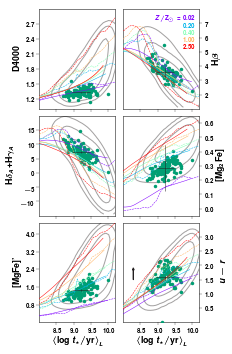

In [8]:
mask = (m16["LOSVD_mod"]==40.0)&(m16["log_t_L_mod"]<9.0)&(col<2.22)
NG = mask.sum()
prior = ssa

# prior_subset = copy(m16[mask][:NG][["input_file","Av_mod"]])
# prior_subset["input_file"] = map(lambda name: "processed_SPEC_"+name.replace(".fit", ".txt"), m16[mask]["input_file"][:NG])
# for file, Av in zip(prior_subset["input_file"], prior_subset["Av_mod"]):
#     f = open("../inputs/real_deal/spec/{}".format(file), "r")
#     o = open("../inputs/real_deal/spec/g05-prior-{}".format(file), "w")
    
#     o.write("# LOSVD = 0.0\n")
#     o.write("# Av    = {0:.5f}\n".format(Av))
#     o.writelines(f.readlines()[2:])
#     f.close()
#     o.close()

colors = cm.rainbow(linspace(0,1,len(libraries["stelib"])))
properties = ["D4000", "Hbeta", "Hdg", "Mg2Fe", "MgFep", "u-r"]

fig, axs = subplots(3, 2, sharex=True, figsize=(3.3,5))

axs = axs.ravel()
xl = axs[0].set_xlim(8.0,10.2)
axs[0].xaxis.set_major_locator(MaxNLocator(nbins=5, prune="both"))
yls = ((1.0,3.0), (1.0,8.0), (-15,20), (-0.05,0.65), (0.0,4.5), (0.0,3.5))

for i in xrange(axs.size):
    prop = properties[i]
    
    axs[i].set_ylabel(ax_ylabels[prop])
    if axs[i].is_last_row(): axs[i].set_xlabel(params["log_t_L"])
    axs[i].set_ylim(yls[i])
    axs[i].yaxis.set_major_locator(MaxNLocator(nbins=7, prune="both"))
    if axs[i].is_last_col():
        axs[i].tick_params(left=False, labelleft=False, right=True, labelright=True)
        axs[i].yaxis.set_label_position("right")
    if i==5:
        axs[i].arrow(8.3, 1.5, 0.0, mean(g_z_red), overhang=0, head_width=0.05, color=samples["dark"])
        #axs[i].annotate("", (8.3,1.5+mean(g_z_red)), (8.3,1.5), arrowprops=dict(arrowstyle="->"), color=samples["dark"])

    for j, zkw in enumerate(sorted(libraries["stelib"])):
        if i==1:
            axs[i].text(0.93, 0.89-j*0.07, (r"\bf $Z/\text{Z}_\odot=%s$" if j==0 else r"\bf $%s$")%(libraries["stelib"][zkw]), color=colors[j], fontsize="x-small", ha="right", transform=axs[i].transAxes)
        axs[i].plot(tau0_stelib[zkw]["age"], tau0_stelib[zkw][prop], "--", lw=0.5, color=colors[j], zorder=8)
        axs[i].plot(tau5_stelib[zkw]["age"], tau5_stelib[zkw][prop], "-", lw=0.5, color=colors[j], zorder=8)

    x_, y_, xer_, yer_ = 0.0, 0.0, 0.0, 0.0
    for index in xrange(NG):
        x_ += g05[mask][index]["log_t_L_mod"]
        y_ += mod[mask][index][prop]
        xer_ += g05[mask][index]["t_P84p0"] - g05[mask][index]["t_P16p0"]
        yer_ += mod[mask][index]["{}_err".format(prop)]

        axs[i].plot(g05[mask][index]["log_t_L_mod"], mod[mask][index][prop], ".", ms=7, mew=0, color=seds["sdss"], zorder=7)

    x_, y_, xer_, yer_ = x_/NG, y_/NG, xer_/NG, yer_/NG
    axs[i].errorbar(x_, y_, yer_, xer_, fmt="", ecolor=samples["dark"], elinewidth=0.5, mew=0.5, zorder=9)

#     prior_pdf, xe, ye = histogram2d(prior["age"], prior[prop], (30,30), [last(30,xl),last(30,yls[i])], normed=True)
#     axs[i].pcolormesh(xe[:-1], ye[:-1], prior_pdf.T, cmap=greys_map, vmin=prior_pdf.min(), vmax=prior_pdf.max(), edgecolor="face")
    sample_data = densitycontour.ScatterData(prior["age"], prior[prop])
    raster = sample_data.rasterize(nbins_x=30, nbins_y=30, clipping=[last(30,xl),last(30,yls[i])])
    raster.pdf = gaussian_filter(raster.pdf, sigma=1.5)
    contours = densitycontour.NaiveContourVisualizer(raster, mode="nearest")
    cont = contours.plot((0.99,0.95,0.68), axes=axs[i], linewidths=1.0, colors=samples["medium"])
#     contours.cilabel(cont, fontsize=5, fmt=r"\bf %.0f", inline=True)

fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.07)

fig.savefig("{}g05_indices".format(odir))

In [9]:
properties = ["D4000", "Hbeta", "Hdg", "Mg2Fe", "MgFep"]
likelihood = zeros((NG,ssa.size))
for i in xrange(NG):
    likelihood[i] = product([gaussian(mod[mask][prop+"_err"][i]*randn()+mod[mask][prop][i]-prior[prop], mod[mask][prop+"_err"][i]) for prop in properties], 0)

nb = 1000
xlm, ylm = (prior["age"].min(), prior["age"].max()), (prior["met"].min(),prior["met"].max())
t_mode, Z_mode = zeros(NG), zeros(NG)
for i in xrange(NG):
    t_pdf, te = histogram(prior["age"], nb, range=xlm, density=True, weights=likelihood[i])
    t = (te[1:] + te[:-1])*0.5
    t_pdf /= trapz(t_pdf, t)
    t_mode[i] = t[argmax(t_pdf)]
#     t_mode[i] = t[argmin(abs(median(t_pdf)-t_pdf))]
    
    Z_pdf, Ze = histogram(prior["met"], nb, range=ylm, density=True, weights=likelihood[i])
    Z = (Ze[1:] + Ze[:-1])*0.5
    Z_pdf /= trapz(Z_pdf, Z)
    Z_mode[i] = Z[argmax(Z_pdf)]
#     Z_mode[i] = Z[argmin(abs(median(Z_pdf)-Z_pdf))]

print NG
print mean(m16[mask]["log_t_L_mod"][:NG]-g05[mask]["log_t_L_mod"][:NG]), mean(m16[mask]["log_Z_L_mod"][:NG]-g05[mask]["log_Z_L_mod"][:NG])

116
-0.619567241379 -0.248368965517


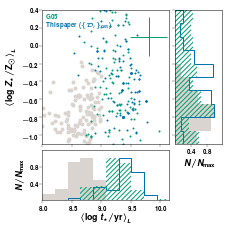

In [10]:
xlm, ylm = (8.0,10.15), (-1.1,0.4)

fig = figure(figsize=(3.3,3.3))
ax11 = subplot2grid((14,14), (0,0), rowspan=10, colspan=10, ylabel=params["log_Z_L"], xticklabels=[], xlim=xlm, ylim=ylm)
ax21 = subplot2grid((14,14), (10,0), rowspan=4, colspan=10, xlabel=params["log_t_L"], ylabel=r"\bf $N/N_\text{max}$", xlim=xlm, ylim=(0.0,1.2))
ax12 = subplot2grid((14,14), (0,10), rowspan=10, colspan=4, xlabel=r"\bf $N/N_\text{max}$", yticklabels=[], xlim=(0.0,1.2), ylim=ylm)

ax21.yaxis.set_major_locator(MaxNLocator(nbins=3, prune="both"))
ax12.xaxis.set_major_locator(MaxNLocator(nbins=3, prune="both"))

axs = array([ax11, ax21, ax12])

fig.tight_layout()
fig.subplots_adjust(hspace=0.7, wspace=0.7)

ax11.plot(m16[mask]["log_t_L_mod"][:NG], m16[mask]["log_Z_L_mod"][:NG], "o", mew=0, ms=4, color=samples["light"])
ax11.plot(g05[mask]["log_t_L_mod"][:NG], g05[mask]["log_Z_L_mod"][:NG], "o", mew=0, ms=2, color=samples["warm"])
ax11.plot(t_mode, Z_mode, "o", mew=0, ms=2, mfc=seds["jpas"])

jj = argmax(g05[mask]["t_P84p0"] - g05[mask]["t_P16p0"])
xerr = (g05[mask][jj]["t_P16p0"] - g05[mask][jj]["t_P84p0"])/2
yerr = (g05[mask][jj]["z_P16p0"] - g05[mask][jj]["z_P84p0"])/2
ax11.errorbar(9.8, 0.1, yerr, xerr, ecolor=samples["warm"])

# sample_data = densitycontour.ScatterData(t_mode, Z_mode)
# raster = sample_data.rasterize(nbins_x=10, nbins_y=10, clipping=[last(10,xlm),last(10,ylm)])
# raster.pdf = gaussian_filter(raster.pdf, sigma=1.5)
# contours = densitycontour.NaiveContourVisualizer(raster, mode="nearest")
# cont = contours.plot((0.99,0.95,0.68), axes=ax11, linewidths=1.0, colors=samples["medium"])
# contours.cilabel(cont, fontsize=5, fmt=r"\bf %.0f", inline=True)

ax11.text(0.02, 0.90, r"\bf This paper ($\{\mathcal{D}_i\}_\text{G05}$)", color=seds["jpas"], size="x-small", ha="left", va="top", transform=ax11.transAxes)
ax11.text(0.02, 0.97, r"\bf G05", color=samples["warm"], size="x-small", ha="left", va="top", transform=ax11.transAxes)

ax21.hist(m16[mask]["log_t_L_mod"][:NG], 10, xlm, weights=1.0/histogram(m16[mask]["log_t_L_mod"][:NG],10,xlm)[0].max().repeat(m16[mask]["log_t_L_mod"][:NG].size), histtype="stepfilled", lw=0, color=samples["light"])
ax21.hist(t_mode, 10, xlm, weights=1.0/histogram(t_mode,10,xlm)[0].max().repeat(t_mode.size), histtype="step", color=seds["jpas"])
ax21.hist(g05[mask]["log_t_L_mod"][:NG], 10, xlm, weights=1.0/histogram(g05[mask]["log_t_L_mod"][:NG],10,xlm)[0].max().repeat(g05[mask]["log_t_L_mod"][:NG].size), histtype="step", lw=0, color=samples["warm"], hatch=5*"/")

ax12.hist(m16[mask]["log_Z_L_mod"][:NG], 10, ylm, weights=1.0/histogram(m16[mask]["log_Z_L_mod"][:NG],10,ylm)[0].max().repeat(m16[mask]["log_Z_L_mod"][:NG].size), orientation="horizontal", histtype="stepfilled", lw=0, color=samples["light"])
ax12.hist(Z_mode, 10, ylm, weights=1.0/histogram(Z_mode,10,ylm)[0].max().repeat(Z_mode.size), histtype="step", color=seds["jpas"], orientation="horizontal")
ax12.hist(g05[mask]["log_Z_L_mod"][:NG], 10, ylm, weights=1.0/histogram(g05[mask]["log_Z_L_mod"][:NG],10,ylm)[0].max().repeat(g05[mask]["log_Z_L_mod"][:NG].size), orientation="horizontal", histtype="step", lw=0, color=samples["warm"], hatch=5*"/")

fig.savefig("{}g05_posterior".format(odir))

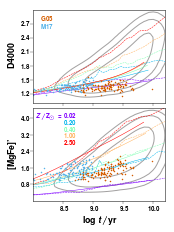

In [11]:
mask = (m16["LOSVD_mod"]==40.0)&(m16["log_t_L_mod"]<9.0)&(col<2.22)
NG = mask.sum()
prior = ssa_dusty

# prior_subset = copy(m16[mask][:NG][["input_file","Av_mod"]])
# prior_subset["input_file"] = map(lambda name: "processed_SPEC_"+name.replace(".fit", ".txt"), m16[mask]["input_file"][:NG])
# for file, Av in zip(prior_subset["input_file"], prior_subset["Av_mod"]):
#     f = open("../inputs/real_deal/spec/{}".format(file), "r")
#     o = open("../inputs/real_deal/spec/g05-prior-{}".format(file), "w")
    
#     o.write("# LOSVD = 0.0\n")
#     o.write("# Av    = {0:.5f}\n".format(Av))
#     o.writelines(f.readlines()[2:])
#     f.close()
#     o.close()

colors = cm.rainbow(linspace(0,1,len(libraries["stelib"])))
properties = ["D4000", "Hbeta", "Hdg", "Mg2Fe", "MgFep", "u-r"]
properties = ["D4000", "MgFep"]

fig, axs = subplots(len(properties), sharex=True, figsize=(2.5,3.3))

xl = axs[0].set_xlim(8.0,10.2)
axs[0].xaxis.set_major_locator(MaxNLocator(nbins=5, prune="both"))
yls = ((1.0,3.0), (0.0,8.0), (-15,20), (-0.05,0.65), (0.0,4.5), (0.0,4.0))
yls = ((1.0,3.0), (0.0,4.5))

for i in xrange(axs.size):
    prop = properties[i]
    
    axs[i].set_ylabel(ax_ylabels[prop])
    if axs[i].is_last_row(): axs[i].set_xlabel(ax_xlabel["age"])
    axs[i].set_ylim(yls[i])
    axs[i].yaxis.set_major_locator(MaxNLocator(nbins=7, prune="both"))
    if i==5:
        axs[i].arrow(8.3, 2.5, 0.0, mean(g_z_red), overhang=0, head_width=0.03, color=samples["dark"])

    for j, zkw in enumerate(sorted(libraries["stelib"])):
        if i==1:
            axs[i].text(0.32, 0.89-j*0.07, (r"\bf $Z/\text{Z}_\odot=%s$" if j==0 else r"\bf $%s$")%(libraries["stelib"][zkw]), color=colors[j], fontsize="x-small", ha="right", transform=axs[i].transAxes)
        axs[i].plot(tau0_stelib[zkw]["age"], tau0_stelib[zkw][prop], "--", lw=0.5, color=colors[j])
        axs[i].plot(tau5_stelib[zkw]["age"], tau5_stelib[zkw][prop], "-", lw=0.5, color=colors[j])

    x_, y_, xer_, yer_ = 0.0, 0.0, 0.0, 0.0
    for index in xrange(NG):
        x_ += g05[mask][index]["log_t_L_mod"]
        y_ += mod[mask][index][prop]
        xer_ += g05[mask][index]["t_P84p0"] - g05[mask][index]["t_P16p0"]
        yer_ += mod[mask][index]["{}_err".format(prop)]

        axs[i].plot(g05[mask][index]["log_t_L_mod"], mod[mask][index][prop], ".", ms=3, mew=0, color=samples["hot"])
        axs[i].plot(m16[mask][index]["log_t_L_mod"], mod[mask][index][prop], ".", ms=3, mew=0, color=samples["cold"])

    x_, y_, xer_, yer_ = x_/NG, y_/NG, xer_/NG, yer_/NG
    #axs[i].errorbar(10.0, y_, yer_, fmt="", ecolor=samples["dark"], elinewidth=0.7, mew=0.7, zorder=9)

#     prior_pdf, xe, ye = histogram2d(prior["age"], prior[prop], (30,30), [last(30,xl),last(30,yls[i])], normed=True)
#     axs[i].pcolormesh(xe[:-1], ye[:-1], prior_pdf.T, cmap=greys_map, vmin=prior_pdf.min(), vmax=prior_pdf.max(), edgecolor="face")
    sample_data = densitycontour.ScatterData(prior["age"], prior[prop])
    raster = sample_data.rasterize(nbins_x=30, nbins_y=30, clipping=[last(30,xl),last(30,yls[i])])
    raster.pdf = gaussian_filter(raster.pdf, sigma=1.5)
    contours = densitycontour.NaiveContourVisualizer(raster, mode="nearest")
    cont = contours.plot((0.99,0.95,0.68), axes=axs[i], linewidths=1.0, colors=samples["medium"])
#     contours.cilabel(cont, fontsize=5, fmt=r"\bf %.0f", inline=True)

axs[0].text(0.05, 0.93, r"\bf G05", color=samples["hot"], fontsize="x-small", ha="left", va="top", transform=axs[0].transAxes)
axs[0].text(0.05, 0.85, r"\bf M17", color=samples["cold"], fontsize="x-small", ha="left", va="top", transform=axs[0].transAxes)

fig.tight_layout()
fig.subplots_adjust(hspace=0.05)

#fig.savefig("{}g05_indices".format("img/"))